In [1]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import re

%matplotlib inline

/Users/zytec/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 数据读取

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
print('共有{}条数据.'.format(len(df)))
print('幸存者{}人.'.format(df.Survived.sum()))

共有891条数据.
幸存者342人.


## 数据分析

#### Pclass 代表社会经济状况，数字越小状况越好 1 = upper, 2 = mid, 3 = lower

In [5]:
df.Pclass.value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

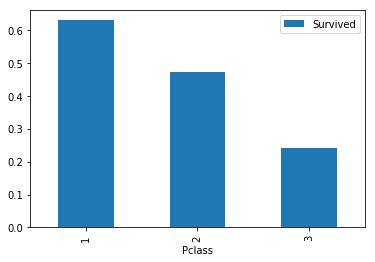

In [6]:
df[['Pclass', 'Survived']].groupby(['Pclass']).mean().plot(kind='bar')

*社会等级越高，幸存率越高*

In [7]:
df['P1'] = (df.Pclass == 1).astype('int')
df['P2'] = (df.Pclass == 2).astype('int')
df['P3'] = (df.Pclass == 3).astype('int')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,P1,P2,P3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,1


#### Sex male时为1， female时为0

In [8]:
df.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

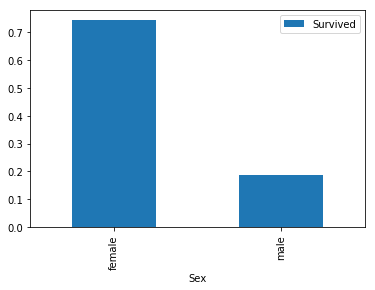

In [9]:
df[['Sex', 'Survived']].groupby(['Sex']).mean().plot(kind='bar')

*女性的幸存率比较高*

In [10]:
df.Sex.replace(['male', 'female'], [1, 0], inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,P1,P2,P3
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,0,1


#### Age 有缺失值，简单用平均值填充

In [11]:
df.Age.isnull().sum()

177

In [12]:
df.Age.fillna(df.Age.mean(), inplace=True)

In [13]:
df['Age_categories'] = pd.cut(df['Age'], 5)

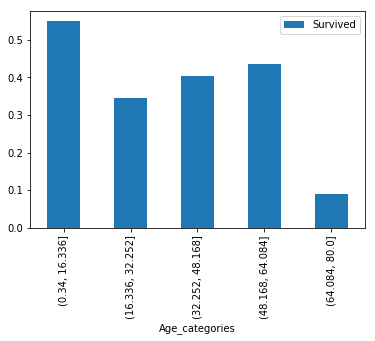

In [14]:
df[['Age_categories', 'Survived']].groupby(['Age_categories']).mean().plot(kind='bar')

*可见小孩的幸存率比较高*

#### Sibsp	在船上的旁系亲属和配偶的数量

In [15]:
df.SibSp.isnull().sum()

0

#### Parch	在船上的父母子女的数量

In [16]:
df.Parch.isnull().sum()

0

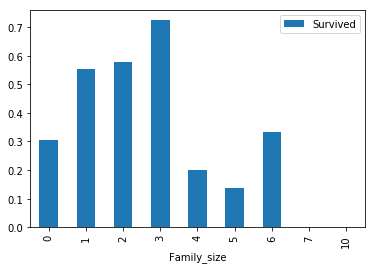

In [17]:
df['Family_size'] = df['SibSp'] + df['Parch']
df[['Family_size', 'Survived']].groupby(['Family_size']).mean().plot(kind='bar')

*亲属和配偶的数量和父母子女的数量合并为一个特征*

#### Fare	船费

In [18]:
df.Fare.isnull().sum()

0

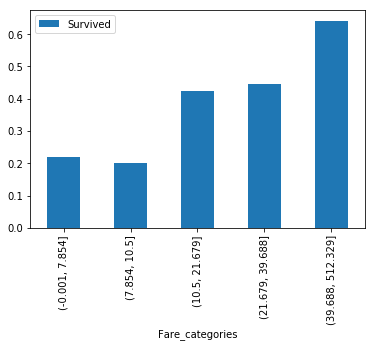

In [19]:
df['Fare_categories'] = pd.qcut(df['Fare'], 5)
df[['Fare_categories', 'Survived']].groupby(['Fare_categories']).mean().plot(kind='bar')

*票价越贵，乘客越有钱，幸存几率越大*

#### Embarked	登船港口 C = Cherbourg, Q = Queenstown, S = Southampton

In [20]:
df.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

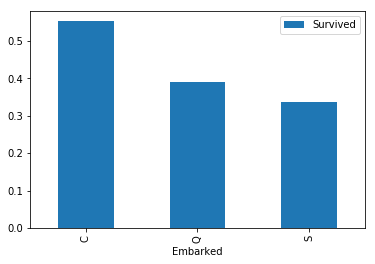

In [21]:
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().plot(kind='bar')

*可以看到在Cherbourg登陆的乘客幸存几率大*

In [22]:
df['E1'] = (df['Embarked'] == 'S').astype('int')
df['E2'] = (df['Embarked'] == 'C').astype('int')
df['E3'] = (df['Embarked'] == 'Q').astype('int')
df['E4'] = (df['Embarked'].isnull()).astype('int')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,P1,P2,P3,Age_categories,Family_size,Fare_categories,E1,E2,E3,E4
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,0,1,"(16.336, 32.252]",1,"(-0.001, 7.854]",1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,1,0,0,"(32.252, 48.168]",1,"(39.688, 512.329]",0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,1,"(16.336, 32.252]",0,"(7.854, 10.5]",1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,1,0,0,"(32.252, 48.168]",1,"(39.688, 512.329]",1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,0,1,"(32.252, 48.168]",0,"(7.854, 10.5]",1,0,0,0


#### 称谓，Mr、Miss、Master ...

In [23]:
def parse_title(name):
    match = re.match(r'\w+\,\s(\w+)\.\s', name)
    if match:
        return match.group(1)
    else:
        return np.nan

In [24]:
df['Title'] = df.Name.apply(parse_title)
df.Title.fillna('NoTitle', inplace=True)
df.Title.value_counts(dropna=False)

Mr          493
Miss        172
Mrs         119
NoTitle      46
Master       39
Dr            6
Rev           6
Major         2
Mlle          2
Mme           1
Col           1
Don           1
Ms            1
Capt          1
Jonkheer      1
Name: Title, dtype: int64

In [25]:
title_set = set(df.Title)
for i, title in enumerate(title_set):
    df['T'+str(i)] = (df.Title == title).astype('int')

In [26]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,0,0


### 预处理后的数据

In [27]:
df_processed = df[['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'P1', 'P2', 'P3',
                   'E1', 'E2', 'E3', 'E4', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5',
                   'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14']]
df_processed.head(3)

,Survived,Sex,Age,SibSp,Parch,Fare,P1,P2,P3,E1,...,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
0,0,1,22.0,1,0,7.2500,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,38.0,1,0,71.2833,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## 划分训练集和测试集

In [28]:
total_X = df_processed.iloc[:, 1:].values
total_Y = df_processed.iloc[:, 0].values

In [29]:
train_X, test_X, train_Y, test_Y = train_test_split(total_X, total_Y, test_size=0.25)

## 数据标准化

In [30]:
X_scaler = StandardScaler()
train_X_std = X_scaler.fit_transform(train_X)
test_X_std = X_scaler.transform(test_X)

### SVM超参数网格搜索

In [37]:
svm = SVC()

params = {
    'C': np.logspace(1, (2 * np.random.rand()), 10),
    'gamma':np.logspace(-4, (2 * np.random.rand()), 10)
}

grid_search = GridSearchCV(svm, params, cv=3)
grid_search.fit(train_X_std, train_Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([10.     , 11.17635, 12.49109, 13.96048, 15.60272, 17.43815,
       19.48949, 21.78214, 24.34449, 27.20826]), 'gamma': array([1.00000e-04, 3.92350e-04, 1.53938e-03, 6.03977e-03, 2.36970e-02,
       9.29754e-02, 3.64789e-01, 1.43125e+00, 5.61550e+00, 2.20324e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
best_score = grid_search.best_score_

0.8323353293413174

In [43]:
best_params = grid_search.best_params_
C = best_params['C']
gamma = best_params['gamma']
C, gamma

(15.602721108193238, 0.006039774114125641)

In [44]:
grid_search.score(test_X_std, test_Y)

0.8430493273542601

In [48]:
predicts = grid_search.predict(test_X_std)
print(metrics.classification_report(test_Y, predicts))

             precision    recall  f1-score   support

          0       0.83      0.91      0.87       128
          1       0.87      0.75      0.80        95

avg / total       0.85      0.84      0.84       223



## 最终预测

In [51]:
total_X_std = X_scaler.transform(df_processed.iloc[:, 1:].values)
total_Y = df_processed.iloc[:, 0]

In [52]:
svm = SVC(C=C, gamma=gamma)
svm.fit(total_X_std, total_Y)

SVC(C=15.602721108193238, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.006039774114125641,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [53]:
svm.score(total_X_std, total_Y)

0.8484848484848485

In [54]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [55]:
test_df.Sex.replace(['male', 'female'], [1, 0], inplace=True)
test_df.Age.fillna(df.Age.mean(), inplace=True)
test_df['P1'] = (df.Pclass == 1).astype('int')
test_df['P2'] = (df.Pclass == 2).astype('int')
test_df['P3'] = (df.Pclass == 3).astype('int')
test_df['E1'] = (df['Embarked'] == 'S').astype('int')
test_df['E2'] = (df['Embarked'] == 'C').astype('int')
test_df['E3'] = (df['Embarked'] == 'Q').astype('int')
test_df['E4'] = (df['Embarked'].isnull()).astype('int')
test_df['Title'] = df.Name.apply(parse_title)
test_df.Title.fillna('NoTitle', inplace=True)
title_set = set(df.Title)
for i, title in enumerate(title_set):
    test_df['T'+str(i)] = (test_df.Title == title).astype('int')

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,0,0,0,0,0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,0,0,0,0,0


In [56]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
P1               0
P2               0
P3               0
E1               0
E2               0
E3               0
E4               0
Title            0
T0               0
T1               0
T2               0
T3               0
T4               0
T5               0
T6               0
T7               0
T8               0
T9               0
T10              0
T11              0
T12              0
T13              0
T14              0
dtype: int64

In [57]:
test_df.Fare.fillna(test_df.Fare.mean(), inplace=True)

In [58]:
test_df_processed = test_df[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'P1', 'P2', 'P3',
                   'E1', 'E2', 'E3', 'E4', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5',
                   'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14']]
test_df_processed.head(3)

,Sex,Age,SibSp,Parch,Fare,P1,P2,P3,E1,E2,...,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14
0,1,34.5,0,0,7.8292,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,47.0,1,0,7.0000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,62.0,0,0,9.6875,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
final_X = test_df_processed.values
final_X_std = X_scaler.transform(final_X)

### 预测

In [60]:
predicts = svm.predict(final_X_std)

In [61]:
ids = test_df['PassengerId'].values

In [62]:
result = pd.DataFrame({
    'PassengerId': ids,
    'Survived': predicts
})

In [63]:
result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [64]:
result.to_csv('./2018-5-24_6.csv', index=False)